In [11]:
# %load_ext autoreload
# %autoreload 2

import sys
sys.path.append('..')

from lib.obs import asos_raw, hourly_precip
from events_calc import precip_events

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
def precip_temp(precip_hrs, obs):
    precip_clusts = precip_events(precip_hrs, eps=6, min_samples=6)
    
    events = precip_hrs.copy()
    events['clust'] = precip_clusts
    events = events[events.clust >= 0]
    events['hour'] = events.valid.dt.hour
    events['date'] = events.valid.dt.date.astype('datetime64')
    
    temp_obs = obs.copy()
    temp_obs['date'] = temp_obs.valid.dt.date.astype('datetime64')
    temp_obs['hour'] = temp_obs.valid.dt.hour
    temp_obs_mean = temp_obs.groupby(['date', 'hour'], as_index=False).mean()[['date', 'hour', 'tmpf']]
    
    merged = events.merge(temp_obs_mean, on=['date', 'hour'], how='left')
    events_agg = merged.groupby('clust', as_index=False).agg({
        'precip_in': sum,
        'valid': ['min','max'],
        'tmpf': 'mean'
    })
    events_agg.columns.droplevel(level=0)
    events_agg.columns = ['clust', 'precip', 'start_time', 'end_time', 'temp'] 
    del events_agg['clust']
    return events_agg

In [33]:
station = 'SFO'
time_periods = [
#     ('1970-07-01', '1980-06-30'),
#     ('1980-07-01', '1990-06-30'),
    ('1990-07-01', '2000-06-30'),
    ('2000-07-01', '2010-06-30'),
    ('2010-07-01', '2020-06-30')
]

In [37]:
dfs = []
for period in time_periods:
    obs = asos_raw(station, *period)
    precip = hourly_precip(station, *period)
    events = precip_temp(precip, obs)
    dfs.append(events[events.start_time.dt.month.isin([12, 1, 2, 3])])
    
all_events = pd.concat(dfs)

/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3347: DtypeWarning: Columns (28) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3347: DtypeWarning: Columns (28) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3347: DtypeWarning: Columns (28) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3347: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.

In [79]:
good_events = all_events[all_events.start_time.dt.year >= 1990]

In [87]:
one_sd_wet = good_events.precip.mean() + 1.5 * good_events.precip.std()
one_sd_wet

1.4818643170831587

In [84]:
warmest_wet = good_events[good_events.precip >= one_sd_wet].sort_values(by='temp').tail(10)
coldest_wet = good_events[good_events.precip >= one_sd_wet].sort_values(by='temp').head(10)

In [85]:
warmest_wet.sort_values(by='start_time')

,precip,start_time,end_time,temp
175,1.75,1995-03-08 17:00:00,1995-03-09 20:00:00,59.191250
197,4.14,1995-12-11 09:00:00,1995-12-12 19:00:00,59.275294
252,2.30,1997-01-01 06:00:00,1997-01-02 23:00:00,61.606029
76,2.61,2002-12-13 09:00:00,2002-12-14 09:00:00,59.579600
78,2.38,2002-12-15 18:00:00,2002-12-16 18:00:00,58.236000
203,2.40,2005-12-30 17:00:00,2005-12-31 20:00:00,59.830250
127,3.58,2014-12-02 09:00:00,2014-12-04 17:00:00,59.780476
170,1.61,2016-03-05 21:00:00,2016-03-06 13:00:00,58.534500
198,1.78,2017-01-08 04:00:00,2017-01-09 08:00:00,59.656000
209,1.52,2017-02-06 01:00:00,2017-02-07 18:00:00,58.672929


In [86]:
coldest_wet.sort_values(by='start_time')

,precip,start_time,end_time,temp
77,2.49,1993-01-05 23:00:00,1993-01-07 11:00:00,43.964375
181,1.83,1995-03-22 09:00:00,1995-03-23 07:00:00,49.329091
12,1.78,2001-01-10 15:00:00,2001-01-12 01:00:00,49.927520
154,2.57,2004-12-27 01:00:00,2004-12-28 10:00:00,50.254000
297,2.32,2008-01-25 11:00:00,2008-01-26 08:00:00,50.483158
333,2.70,2009-02-15 10:00:00,2009-02-17 00:00:00,48.270714
362,3.69,2010-01-19 11:00:00,2010-01-22 02:00:00,49.411413
23,1.72,2011-02-18 18:00:00,2011-02-20 00:00:00,43.305000
29,1.84,2011-03-18 07:00:00,2011-03-20 13:00:00,49.416286
189,1.76,2016-12-07 23:00:00,2016-12-09 02:00:00,50.600000


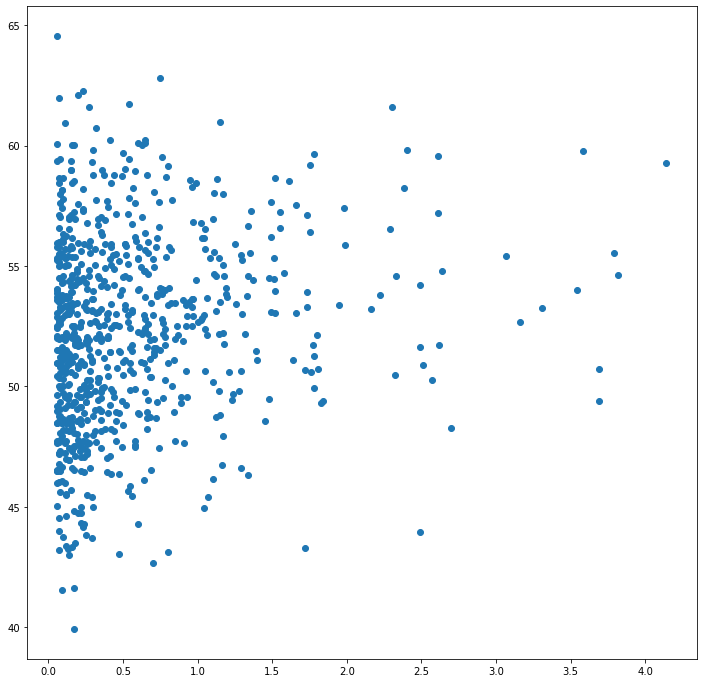

In [88]:
plt.figure(figsize=(12, 12))
plt.scatter(x=good_events.precip, y=good_events.temp)